<img src = 'https://drive.google.com/uc?id=12INTwNhPoUzlO0C36DBzHcqm7AH8rjZw' height = 275, width = 2750>


# Imports

In [ ]:
import os
import cv2 
import random
import tensorflow as tf
import warnings
import numpy as np
import pandas as pd
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle, class_weight
from sklearn.metrics import confusion_matrix,classification_report, cohen_kappa_score,f1_score
from tensorflow.python.keras.metrics import Metric
from tensorflow.keras import backend as K
from keras.models import Model,load_model
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint,CSVLogger
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

%matplotlib inline
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (18,10)

warnings.filterwarnings("ignore")

In [ ]:
# Set seeds to make the experiment more reproducible.
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(0)
seed_everything()

# Some Helpers

In [ ]:
def warmup_lr_scheduler(epoch, lr):
    '''
    This function is use to increase the warmup learning rate linearly each iteration.
    Assume the total warmup epochs = 5 and the max learning rate = 1e-3.

    epoch：current epoch
    lr: current learning rate 

    return float number
    '''
    warmup_epochs = 5
    max_lr = 1e-3
    increase_rate = max_lr / warmup_epochs
    return lr + increase_rate




class f1_score(Callback):
    '''
    A simaple call back for getting the average macro f1_score each step.
      
    val_data: validation generator
    batch_size: model batch size
    save_best_mod: whether or not save the model weights as the macro f1_score is higher than before
    file_name: define the file name, the file will be over written by the current best macro f1_score

    return None
    ''' 
    def __init__(self, val_data, batch_size = 16,save_best_mod = False,file_name = ''):
        super().__init__()
        self.validation_data = val_data
        self.batch_size = batch_size
        self.save_best_mod = save_best_mod
        self.file_name = file_name
    
    def on_train_begin(self, logs={}):
        '''Initialize f1 score and best f1 score of the validation set.'''
        #print(self.validation_data)
        self.val_f1s = []
        self.best_val_f1 = 0
        #self.val_recalls = []
        #self.val_precisions = []
        
    def on_epoch_end(self, epoch, logs={}):
        '''Calculate f1 socre at the end of each eopch and save model weights for the best f1 score'''
        batches = len(self.validation_data)
        val_pred = []
        val_true = []
        
        for batch in range(batches):
            xVal, yVal = next(self.validation_data)

            val_pred = np.concatenate((val_pred,np.argmax(self.model.predict(xVal),-1)),axis = None)
            val_true = np.concatenate((val_true,np.argmax(yVal,-1)),axis = None)
        
        _val_f1 = f1_score(val_true, val_pred,average = 'macro')
        #_val_precision = precision_score(val_true, val_pred)
        #_val_recall = recall_score(val_true, val_pred)

        if self.save_best_mod == True:
          if _val_f1 > self.best_val_f1:
            self.model.save_weights(mypath + '/output/model/%s_best_valf1_%.4f.h5'%(file_name,_val_f1))
            self.best_val_f1 = _val_f1
            print('Best validation macro f1_score: %.4f so far! Saving model...'%(_val_f1))
        
        self.val_f1s.append(_val_f1)
        print(' - val_macro_f1: %f'%(_val_f1))
        #self.val_recalls.append(_val_recall)
        #self.val_precisions.append(_val_precision)

        return




class QWK_Score(Callback):
    '''
    A simaple call back for getting the average macro f1_score each step.
      
    val_data: validation generator
    batch_size: model batch size
    save_best_mod: whether or not save the model weights as the macro f1_score is higher than before
    file_name: define the file name, the file will be over written by the current best macro f1_score

    return None
    ''' 
    def __init__(self, val_data, batch_size = 16,save_best_mod = False,file_name = ''):
        super().__init__()
        self.validation_data = val_data
        self.batch_size = batch_size
        self.save_best_mod = save_best_mod
        self.file_name = file_name
    
    def on_train_begin(self, logs={}):
        '''Initialize quadratic weighted kappa score and current best quadratic weighted kappa score'''
        self.qwk_scores = []
        self.best_qwk_score = 0
        
    def on_epoch_end(self, epoch, logs={}):
        batches = len(self.validation_data)
        val_pred = []
        val_true = []
        
        for batch in range(batches):
            xVal, yVal = next(self.validation_data)

            val_pred = np.concatenate((val_pred,np.argmax(self.model.predict(xVal),-1)),axis = None)
            val_true = np.concatenate((val_true,np.argmax(yVal,-1)),axis = None)

        _qwk_score = cohen_kappa_score(val_true, val_pred,labels = [0,1,2,3,4],weights = 'quadratic')

        if self.save_best_mod == True:
          if _qwk_score > self.best_qwk_score:
            self.model.save_weights(mypath + '/output/model/%s_best_qwk_%.4f.h5'%(self.file_name,_qwk_score))
            self.best_qwk_score = _qwk_score 
            print('Best qwk_score: %.4f so far! Saving model...'%(_qwk_score))
        
        self.qwk_scores.append(_qwk_score)
        print(' - qwk_score: %f'%(_qwk_score))
   
        return




class LRFinder(Callback):
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 

    min_lr: The lower bound of the learning rate range for the experiment.
    max_lr: The upper bound of the learning rate range for the experiment.
    steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
    epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    References:
    Blog post: jeremyjordan.me/nn-learning-rate
    Original paper: https://arxiv.org/abs/1506.01186
    '''
    
    def __init__(self, min_lr=1e-5, max_lr= 2e-3, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()




def plot_fit_history(fit_hist = []):
    '''
    This function plots the fit history, including the loss on both of the 
    training set and validation set along along with the epochs.
    
    fit_hist: a list of dictionary, where the dictionary is fit history
              (note: if there are more than one fit history, pass them in order,from the 
               earliest to latest.)
    
    return None
    '''
    keys  = ['loss','val_loss']

    append_fit_hist = defaultdict(list)
    for key in keys:
      for h in fit_hist:
        append_fit_hist[key] += h[key]

    total_epoches = len(append_fit_hist[keys[0]])
    plt.plot(append_fit_hist['loss'], label='Train loss')
    plt.plot(append_fit_hist['val_loss'], label='Validation loss')

    plt.xticks(np.arange(total_epoches),np.arange(1,total_epoches + 1))
    plt.legend(loc='best')
    sns.despine()
    plt.show()

# Load Data

In [ ]:
mypath = '/content/drive/MyDrive/APTOS_Blindness_Detection'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv(mypath + '/input/aptos2019-blindness-detection/train.csv')
test = pd.read_csv(mypath + '/input/aptos2019-blindness-detection/test.csv')

# Preprocessing And Modeling

In [ ]:
train_new = train.copy()
train_new.id_code = train_new.id_code + '.png'
train_new = train_new.astype(str)
train_new = shuffle(train_new).reset_index(drop = True)
train_new.to_csv('./train_new.csv',index = False)

test['id_code'] = test.id_code + '.png'

In [ ]:
def create_model(input_shape, n_out):
    '''
    The function is used to Created a ResNet50 Model.
    '''
    input_tensor = Input(shape=input_shape)
    #Include_top lets you select if you want the final dense layers or not.
    base_model = applications.resnet.ResNet50(weights='imagenet',
                                      include_top=False,
                                      input_tensor=input_tensor)

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

## Initialize Model Parameters

In [ ]:
# Model parameters
HEIGHT = 224 #512
WIDTH = 224 #512
BATCH_SIZE = 32
N_CLASSES = train_new['diagnosis'].nunique()

WARMUP_EPOCHS = 5
MAX_WARMUP_LEARNING_RATE = 1e-3
WARMUP_LEARNING_RATE = MAX_WARMUP_LEARNING_RATE / WARMUP_EPOCHS
EPOCHS = 30
LEARNING_RATE = 1e-4
CANAL = 3
ES_PATIENCE = 9
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

## Data generator

In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.2)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train_new,
    directory= mypath + "/input/aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset='training')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train_new,
    directory= mypath + "/input/aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",    
    target_size=(HEIGHT, WIDTH),
    subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = mypath + "/input/aptos2019-blindness-detection/test_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


## Warm up Model

In the Warmup phase, the model will be trained by a small learning rate that grows linearly at the end of each iteration until 5 eopches used up. The start learning rate is 1/5e^-3 and it increases by 1/5e^-3 each time, so at the last epoch, the learning rate will be 1/5e^-3 +  4 x 1/5 e^-3 = 1e^-3. The reason of the Warmup behind is to avoid the weights fluctuating drastincally  and deviating from the optima further in early training. Thus, I also freeze the layers under the top 5 in this phase to make the training more stable.

### Batch size = 32

In [ ]:
model_1 = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model_1.layers:
    layer.trainable = False
for i in range(-5, 0):
    model_1.layers[i].trainable = True

metric_list = ['accuracy']
optimizer = tf.keras.optimizers.Adam(lr=WARMUP_LEARNING_RATE)

model_1.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model_1.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
%%time
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

qwk_warmup1 = QWK_Score(valid_generator,BATCH_SIZE)
lrs = LearningRateScheduler(warmup_lr_scheduler,verbose = 1)
csvl = CSVLogger(mypath + '/output/mod1_warmup_log.csv',append = False)
callback_list = [qwk_warmup1,lrs,csvl]


history_warmup1 = model_1.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=WARMUP_EPOCHS,
                              verbose=1,
                              callbacks=callback_list).history

Epoch 1/5

Epoch 00001: LearningRateScheduler setting learning rate to 0.000399999994947575.
91/91 [==============================] - 410s 4s/step - loss: 1.5942 - accuracy: 0.4058 - val_loss: 1.2617 - val_accuracy: 0.4844
 - qwk_score: 0.000000
Epoch 2/5

Epoch 00002: LearningRateScheduler setting learning rate to 0.00059999998989515.
91/91 [==============================] - 403s 4s/step - loss: 1.4383 - accuracy: 0.4486 - val_loss: 1.2954 - val_accuracy: 0.4787
 - qwk_score: 0.000000
Epoch 3/5

Epoch 00003: LearningRateScheduler setting learning rate to 0.0007999999702908099.
91/91 [==============================] - 405s 4s/step - loss: 1.3841 - accuracy: 0.4569 - val_loss: 1.2258 - val_accuracy: 0.5028
 - qwk_score: 0.037761
Epoch 4/5

Epoch 00004: LearningRateScheduler setting learning rate to 0.0009999999797903002.
91/91 [==============================] - 404s 4s/step - loss: 1.3605 - accuracy: 0.4769 - val_loss: 1.2289 - val_accuracy: 0.4801
 - qwk_score: 0.000000
Epoch 5/5

Epoc

## Compare with Other Batch Sizes

### Batch Size = 16


In [ ]:
#update parameters
BATCH_SIZE = 16
train_generator.batch_size = BATCH_SIZE
valid_generator.batch_size = BATCH_SIZE

In [ ]:
model_2 = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model_2.layers:
    layer.trainable = False
for i in range(-5, 0):
    model_2.layers[i].trainable = True

metric_list = ['accuracy']
optimizer = tf.keras.optimizers.Adam(lr=WARMUP_LEARNING_RATE)

model_2.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
%%time
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

#macro_f1 = Metrics(valid_generator,BATCH_SIZE)
qwk_warmup2 = QWK_Score(valid_generator,BATCH_SIZE)
lrs = LearningRateScheduler(warmup_lr_scheduler,verbose = 1)
csvl = CSVLogger(mypath + '/output/log/mod2_warmup_log.csv',append = False)
callback_list = [qwk_warmup2,lrs,csvl]

history_warmup2 = model_2.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs= WARMUP_EPOCHS,
                              verbose=1,
                              callbacks=callback_list).history

Epoch 1/5

Epoch 00001: LearningRateScheduler setting learning rate to 0.000399999994947575.
183/183 [==============================] - 4312s 23s/step - loss: 1.5933 - accuracy: 0.4310 - val_loss: 1.2890 - val_accuracy: 0.4806
 - qwk_score: 0.000000
Epoch 2/5

Epoch 00002: LearningRateScheduler setting learning rate to 0.00059999998989515.
183/183 [==============================] - 395s 2s/step - loss: 1.4277 - accuracy: 0.4485 - val_loss: 1.2692 - val_accuracy: 0.6556
 - qwk_score: 0.614303
Epoch 3/5

Epoch 00003: LearningRateScheduler setting learning rate to 0.0007999999702908099.
183/183 [==============================] - 394s 2s/step - loss: 1.3752 - accuracy: 0.4794 - val_loss: 1.2543 - val_accuracy: 0.5181
 - qwk_score: 0.091421
Epoch 4/5

Epoch 00004: LearningRateScheduler setting learning rate to 0.0009999999797903002.
183/183 [==============================] - 391s 2s/step - loss: 1.3286 - accuracy: 0.4811 - val_loss: 1.2446 - val_accuracy: 0.4833
 - qwk_score: 0.000000
Epoch

### Batch Size = 64

In [ ]:
#update parameters
BATCH_SIZE = 64
train_generator.batch_size = BATCH_SIZE
valid_generator.batch_size = BATCH_SIZE

In [ ]:
model_3 = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model_3.layers:
    layer.trainable = False
for i in range(-5, 0):
    model_3.layers[i].trainable = True

model_3.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
#model_3.summary()

In [ ]:
%%time
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

qwk_warmup3 = QWK_Score(valid_generator,BATCH_SIZE)
lrs = LearningRateScheduler(warmup_lr_scheduler,verbose = 1)
csvl = CSVLogger(mypath + '/output/mod3_warmup_log.csv',append = False)
callback_list = [qwk_warmup3,lrs,csvl]

history_warmup3 = model_3.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs= WARMUP_EPOCHS,
                              verbose=1,
                              callbacks=callback_list).history

Epoch 1/5

Epoch 00001: LearningRateScheduler setting learning rate to 0.0013999999405816198.
45/45 [==============================] - 415s 9s/step - loss: 2.0310 - accuracy: 0.4484 - val_loss: 1.2994 - val_accuracy: 0.4759
 - qwk_score: 0.000000
Epoch 2/5

Epoch 00002: LearningRateScheduler setting learning rate to 0.00159999995008111.
45/45 [==============================] - 400s 9s/step - loss: 1.3178 - accuracy: 0.4916 - val_loss: 1.2689 - val_accuracy: 0.4801
 - qwk_score: 0.000000
Epoch 3/5

Epoch 00003: LearningRateScheduler setting learning rate to 0.0017999999595806004.
45/45 [==============================] - 457s 10s/step - loss: 1.3124 - accuracy: 0.4871 - val_loss: 1.2706 - val_accuracy: 0.4815
 - qwk_score: 0.000000
Epoch 4/5

Epoch 00004: LearningRateScheduler setting learning rate to 0.0019999999690800906.
45/45 [==============================] - 400s 9s/step - loss: 1.2939 - accuracy: 0.4951 - val_loss: 1.2712 - val_accuracy: 0.4801
 - qwk_score: 0.000000
Epoch 5/5

Ep

Warmup model with batch size 16 seems to learn faster than the models with batch size 32 and 64. There are some small changes in qwk score on the validation set over 5 epoches while the qwk scores of other models are mostly 0s. 0 qwk score means the prediction are random. 

In [ ]:
model_2.save_weights(mypath + '/output/model/mod2_warmup.h5')

# Find the Optimal Learning Rate Range

Next, we goal is find the optimal learning rate range for fine-tuning. Similar to the warmup experiment, we will track the loss along with the increasing learning rate, where the min learning rate is 1e^-5 and max learning rate is 3e^-3. Whenever the loss drop the fastest, the corresponsing learning rate helps the model learn fastest.

In [ ]:
BATCH_SIZE = 16
train_datagen.batch_size = BATCH_SIZE
train_generator.batch_size = BATCH_SIZE

In [ ]:
#unfreeze all layers
for layer in model_2.layers:
    layer.trainable = True
    
metrics_list = ['accuracy']
optimizer = tf.keras.optimizers.Adam()
model_2.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=metric_list)
model_2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

qwk = QWK_Score(valid_generator,BATCH_SIZE)
csvl = CSVLogger(mypath + '/output/log/mod2_findlr_log.csv', append = False)
lrf = LRFinder(steps_per_epoch = STEP_SIZE_TRAIN, epochs = 3) 

callback_list = [qwk, csvl, lrf]

history_lr_finder = model_2.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs = 3,
                                          callbacks=callback_list,
                                          verbose=1).history

Epoch 1/3
183/183 [==============================] - 405s 2s/step - loss: 2.0881 - accuracy: 0.6843 - val_loss: 2.0580 - val_accuracy: 0.4764
 - qwk_score: 0.000000
Epoch 2/3
183/183 [==============================] - 391s 2s/step - loss: 0.8066 - accuracy: 0.7265 - val_loss: 47.6484 - val_accuracy: 0.4819
 - qwk_score: 0.000000
Epoch 3/3
183/183 [==============================] - 396s 2s/step - loss: 0.7730 - accuracy: 0.7364 - val_loss: 1.7110 - val_accuracy: 0.4861
 - qwk_score: 0.009256


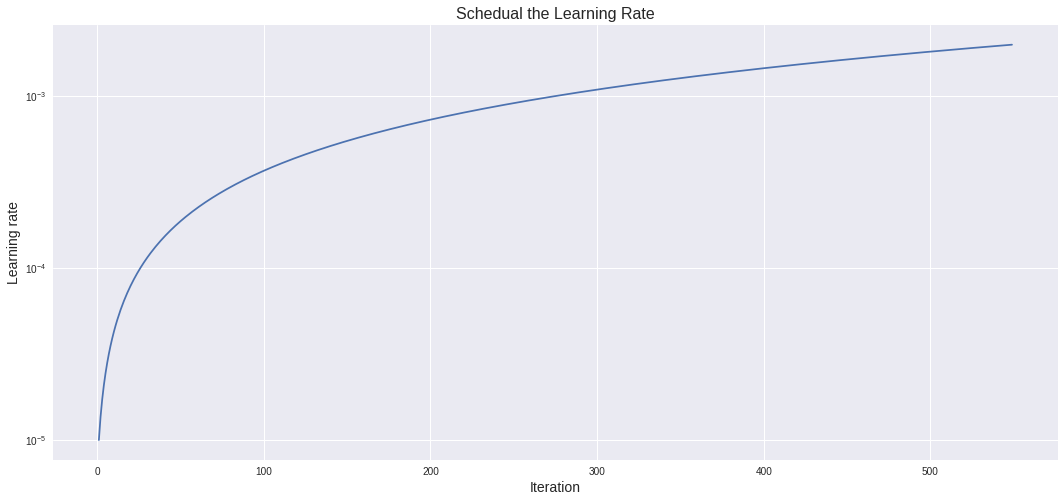

In [ ]:
#@title
plt.figure(figsize = [18,8])
plt.title('Schedual the Learning Rate',fontsize = 16)
plt.xlabel('Iteration', fontsize = 14)
plt.ylabel('Learing Rate', fontsize = 14)
lrf.plot_lr()

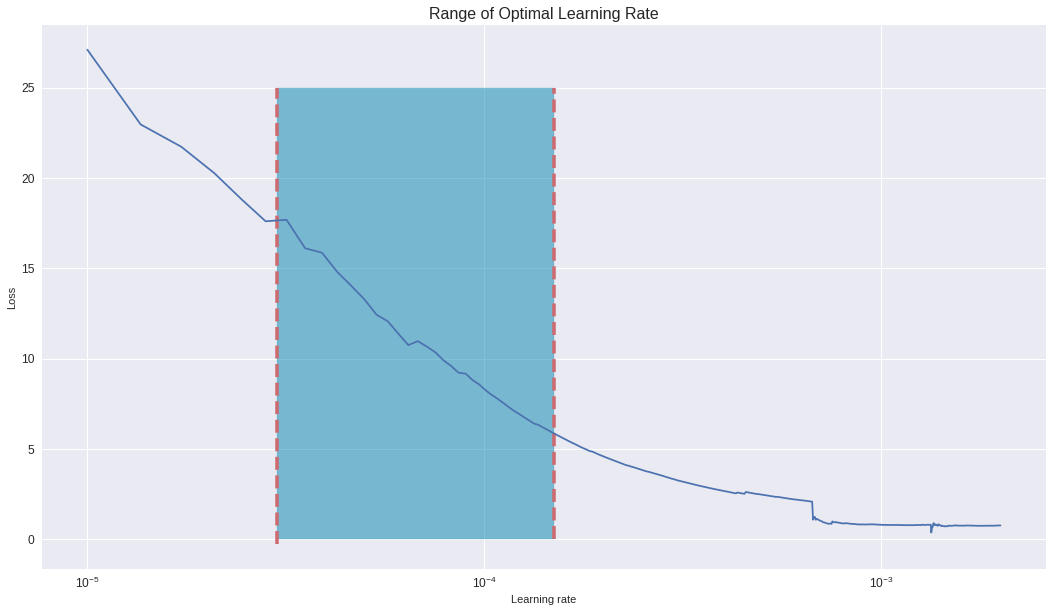

In [ ]:
#@title
plt.figure(figsize = [18,10])
plt.vlines(3e-5, ymin = -0.25, ymax = 25,linestyles = '--', color = '#CC6A70FF',lw = 3.5)
plt.vlines(1.5e-4, ymin = 0, ymax = 25, linestyles= '--', color = '#CC6A70FF', lw = 3.5)
plt.fill_between(y1 = 0, y2 = 25, x = [3e-5, 1.5e-4], color = '#0586B0',alpha = 0.5)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Range of Optimal Learning Rate',fontsize = 16)
lrf.plot_loss()

We can see that the validation loss has the greatest drop rate in the blue region, which means the model learns fastest with learning rates inside the blue region. Such that, I will try 1e-4 and 6e^-5 as the start learning rate , respectively.

In [ ]:
model_2.save_weights(mypath + '/output/model/mod2_findlr.h5')

# Fine-tune the Complete Model

## Option 1: Learning Rating = 1e-4 


In [ ]:
#model_2 = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)
model_2.load_weights(mypath + '/output/model/mod2_warmup.h5')

In [ ]:
#set up the learning rate 
LEARNING_RATE = 1e-4
#BATCH_SIZE = 16
#train_generator.batch_size = BATCH_SIZE 
#valid_generator.batch_size = BATCH_SIZE

In [ ]:
#@title
#unfreeze all layers
for layer in model_2.layers:
    layer.trainable = True
    
metric_list = ['accuracy']
optimizer = tf.keras.optimizers.Adam(lr = LEARNING_RATE)
model_2.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=metric_list)

In [ ]:
#@title
#STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
#STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

qwk = QWK_Score(val_data = valid_generator,batch_size = BATCH_SIZE,save_best_mod = True, file_name = 'mod2')
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, epsilon = 0.0001, factor=DECAY_DROP, min_lr=1e-6, verbose=1)
csvl = CSVLogger(mypath + '/output/log/mod2_finetune_log1.csv',append = False)
cp = ModelCheckpoint(mypath + '/output/model/mod2_finetune1_vloss.h5', monitor='val_loss', verbose=1,
                     save_best_only=True, save_weights_only=True, mode='min', save_freq='epoch')

callback_list = [qwk,es,rlrop,csvl,cp]

history_finetuning1 = model_2.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=EPOCHS,
                              callbacks=callback_list,
                              verbose=1).history

Epoch 1/30
183/183 [==============================] - 411s 2s/step - loss: 1.3675 - accuracy: 0.7066 - val_loss: 8.4276 - val_accuracy: 0.4847
 - qwk_score: 0.000000

Epoch 00001: val_loss improved from inf to 8.42756, saving model to /content/drive/MyDrive/APTOS_Blindness_Detection/output/model/mod2_finetune1_vloss.h5
Epoch 2/30
183/183 [==============================] - 400s 2s/step - loss: 0.6493 - accuracy: 0.7563 - val_loss: 6.4926 - val_accuracy: 0.4819
 - qwk_score: 0.000000

Epoch 00002: val_loss improved from 8.42756 to 6.49261, saving model to /content/drive/MyDrive/APTOS_Blindness_Detection/output/model/mod2_finetune1_vloss.h5
Epoch 3/30
183/183 [==============================] - 397s 2s/step - loss: 0.5564 - accuracy: 0.7859 - val_loss: 6.0491 - val_accuracy: 0.4833
 - qwk_score: 0.000000

Epoch 00003: val_loss improved from 6.49261 to 6.04910, saving model to /content/drive/MyDrive/APTOS_Blindness_Detection/output/model/mod2_finetune1_vloss.h5
Epoch 4/30
183/183 [=========

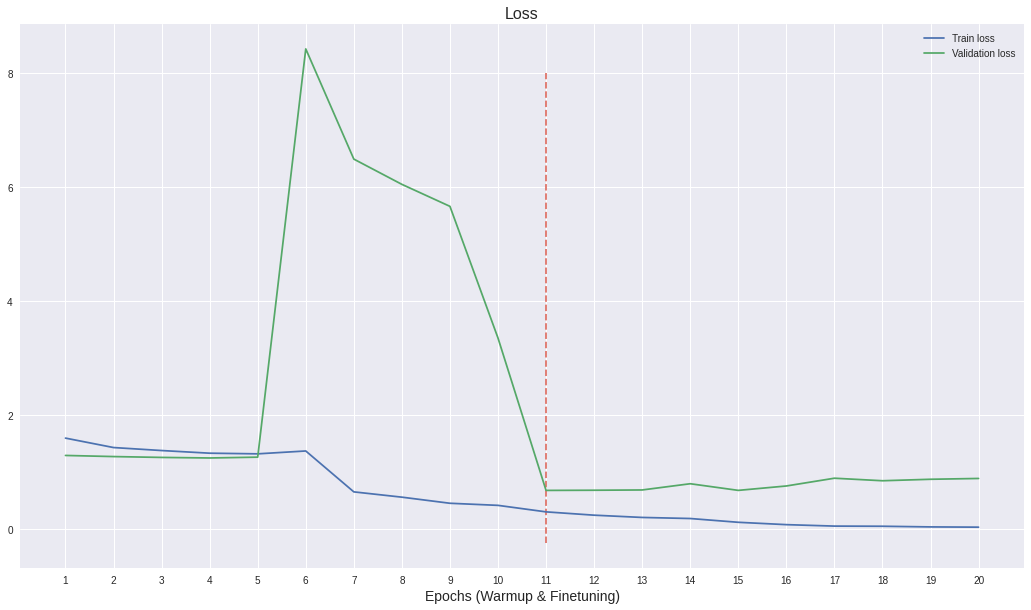

In [ ]:
#@title
plt.vlines(x = 10,ymin = -0.25, ymax = 8, linestyles = '--', color = '#de7065ff')
plt.xlabel('Epochs (Warmup & Finetuning)',fontsize = 14)
plt.title('Loss',fontsize = 16)
plot_fit_history(fit_hist = [history_warmup2,history_finetuning1])

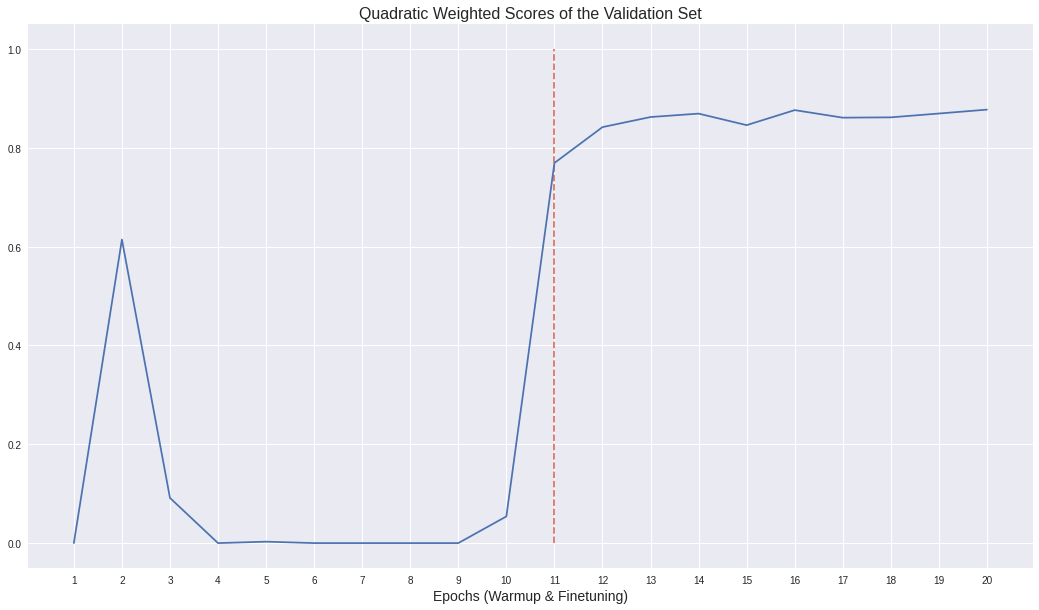

In [ ]:
#@title
total_epoches = len(qwk_warmup2.qwk_scores) + len(qwk.qwk_scores)

plt.plot(qwk_warmup2.qwk_scores + qwk.qwk_scores)
plt.vlines(x = 10,ymin = 0, ymax = 1, linestyles = '--', color = '#de7065ff')
plt.xticks(np.arange(total_epoches),np.arange(1,total_epoches + 1))
plt.xlabel('Epochs (Warmup & Finetuning)',fontsize = 14)
plt.title('Quadratic Weighted Scores of the Validation Set',fontsize = 16);

## Option 2: Learning Rate = 6e-5

In [ ]:
#model_2 = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)
#model_2.load_weights(mypath + '/output/model/mod2_warmup.h5')

In [ ]:
#set up the learning rate 
LEARNING_RATE = 6e-5

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr =LEARNING_RATE)
model_2.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=metric_list)

In [ ]:
qwk = QWK_Score(val_data = valid_generator,batch_size = BATCH_SIZE,save_best_mod = True, file_name = 'mod2')
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, epsilon = 0.0001, factor=DECAY_DROP, min_lr=1e-6, verbose=1)
csvl = CSVLogger(mypath + '/output/log/mod2_finetune_log2.csv',append = False)
cp = ModelCheckpoint(mypath + '/output/model/mod2_finetune2_vloss.h5', monitor='val_loss', verbose=1,
                     save_best_only=True, save_weights_only=True, mode='min', save_freq='epoch')

callback_list = [qwk,es,rlrop,csvl,cp]
history_finetuning2 = model_2.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=EPOCHS,
                              callbacks=callback_list,
                              verbose=1).history

Epoch 1/30
183/183 [==============================] - 407s 2s/step - loss: 0.6199 - accuracy: 0.7800 - val_loss: 1.1306 - val_accuracy: 0.5778
Best qwk_score: 0.2965 so far! Saving model...
 - qwk_score: 0.296486

Epoch 00001: val_loss improved from inf to 1.13061, saving model to /content/drive/MyDrive/APTOS_Blindness_Detection/output/model/mod2_finetune2_vloss.h5
Epoch 2/30
183/183 [==============================] - 397s 2s/step - loss: 0.4995 - accuracy: 0.8150 - val_loss: 0.9441 - val_accuracy: 0.6861
Best qwk_score: 0.5765 so far! Saving model...
 - qwk_score: 0.576502

Epoch 00002: val_loss improved from 1.13061 to 0.94407, saving model to /content/drive/MyDrive/APTOS_Blindness_Detection/output/model/mod2_finetune2_vloss.h5
Epoch 3/30
183/183 [==============================] - 395s 2s/step - loss: 0.4505 - accuracy: 0.8336 - val_loss: 0.6171 - val_accuracy: 0.7694
Best qwk_score: 0.7861 so far! Saving model...
 - qwk_score: 0.786135

Epoch 00003: val_loss improved from 0.94407 to

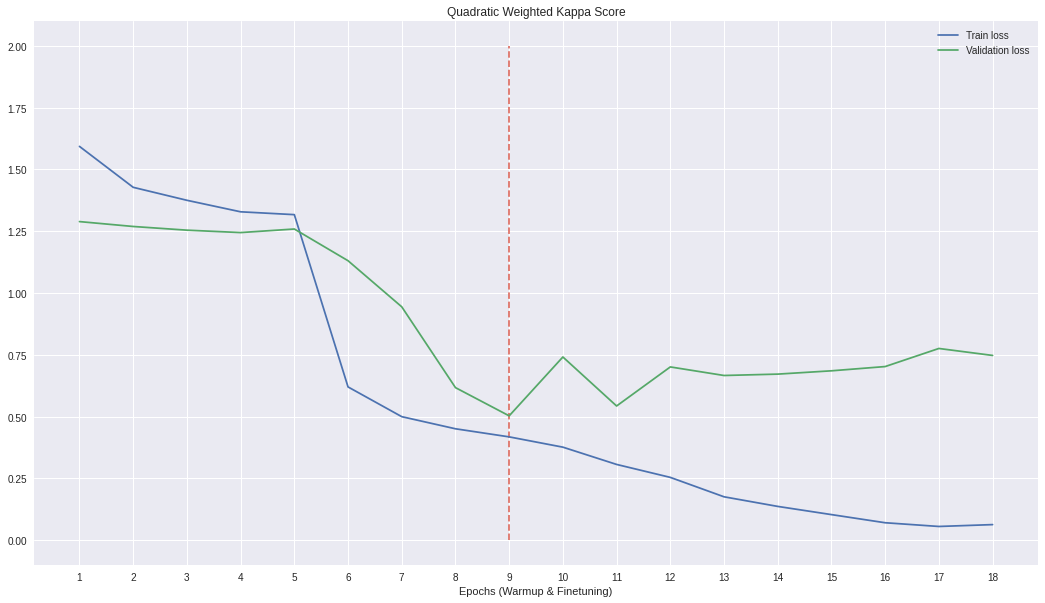

In [ ]:
#@title
plt.vlines(x = 8,ymin = 0, ymax = 2, linestyles = '--', color = '#de7065ff')
plt.xlabel('Epochs (Warmup & Finetuning)')
plt.title('Quadratic Weighted Kappa Score')
plot_fit_history(fit_hist = [history_warmup2,history_finetuning2])

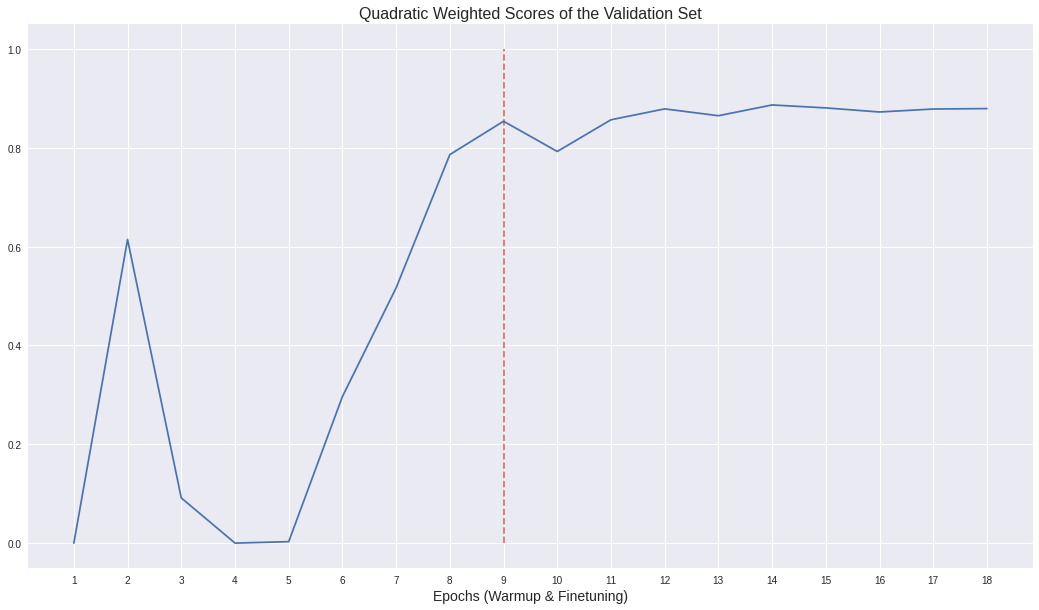

In [ ]:
#@title
total_epoches = len(qwk_warmup2.qwk_scores) + len(qwk.qwk_scores)

plt.plot(qwk_warmup2.qwk_scores + qwk.qwk_scores)
plt.vlines(x = 8,ymin = 0, ymax = 1, linestyles = '--', color = '#de7065ff')
plt.xticks(np.arange(total_epoches),np.arange(1,total_epoches + 1))
plt.xlabel('Epochs (Warmup & Finetuning)',fontsize = 14)
plt.title('Quadratic Weighted Scores of the Validation Set',fontsize = 16);

The best model of start learning rate 6e^-5 outperforms the best model of start learning rate 1e^-4 in val losss and val qwk socre.


*   learning rate 1e^-4 --->    val_loss: 0.6751   qwk_score:0.7692
*   learning rate 6e^-5 --->  val_loss:0.5028    qwk_score:0.8536

Now, we have our first candiate model.


# Use Weighted Loss to Deal with Imbalance Problem

In [ ]:
CLASS_WEIGHTS = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_new['diagnosis']),
                                                 train_new['diagnosis'])
CLASS_WEIGHTS = dict(zip(np.unique(train_new['diagnosis']).astype('int'),CLASS_WEIGHTS))

## Warmup


In [ ]:
#update parameters
BATCH_SIZE = 16
train_generator.batch_size = BATCH_SIZE
valid_generator.batch_size = BATCH_SIZE

In [ ]:
model_wl = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model_wl.layers:
    layer.trainable = False
for i in range(-5, 0):
    model_wl.layers[i].trainable = True

metric_list = ['accuracy']
optimizer = tf.keras.optimizers.Adam(lr=WARMUP_LEARNING_RATE)

model_wl.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)

In [ ]:
%%time
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

#macro_f1 = Metrics(valid_generator,BATCH_SIZE)
qwk_warmup_wl = QWK_Score(valid_generator,BATCH_SIZE)
lrs = LearningRateScheduler(warmup_lr_scheduler,verbose = 1)
csvl = CSVLogger(mypath + '/output/log/modwl_warmup_log.csv',append = False)
callback_list = [qwk_warmup_wl,lrs,csvl]

history_warmup_wl = model_wl.fit_generator(generator=train_generator,
                                         steps_per_epoch=STEP_SIZE_TRAIN,
                                         validation_data=valid_generator,
                                         validation_steps=STEP_SIZE_VALID,
                                         epochs= WARMUP_EPOCHS,
                                         verbose=1,
                                         callbacks=callback_list,
                                         class_weight=CLASS_WEIGHTS).history

Epoch 1/5

Epoch 00001: LearningRateScheduler setting learning rate to 0.000399999994947575.
183/183 [==============================] - 1717s 9s/step - loss: 2.0828 - accuracy: 0.2008 - val_loss: 1.7277 - val_accuracy: 0.1333
 - qwk_score: -0.009398
Epoch 2/5

Epoch 00002: LearningRateScheduler setting learning rate to 0.00059999998989515.
183/183 [==============================] - 447s 2s/step - loss: 1.9002 - accuracy: 0.2179 - val_loss: 1.4011 - val_accuracy: 0.4819
 - qwk_score: 0.000000
Epoch 3/5

Epoch 00003: LearningRateScheduler setting learning rate to 0.0007999999702908099.
183/183 [==============================] - 430s 2s/step - loss: 1.7907 - accuracy: 0.2145 - val_loss: 1.6965 - val_accuracy: 0.1292
 - qwk_score: 0.038386
Epoch 4/5

Epoch 00004: LearningRateScheduler setting learning rate to 0.0009999999797903002.
183/183 [==============================] - 437s 2s/step - loss: 1.7305 - accuracy: 0.2282 - val_loss: 1.5505 - val_accuracy: 0.2819
 - qwk_score: 0.218293
Epoch

In [ ]:
model_wl.save(mypath + '/output/model/modwl_warmup.h5')

## Find the Optimal Learning Rate Range

In [ ]:
#unfreeze all layers
for layer in model_wl.layers:
    layer.trainable = True
    
metrics_list = ['accuracy']
optimizer = tf.keras.optimizers.Adam()
model_wl.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=metric_list)
#model_wl.summary()

In [ ]:
qwk = QWK_Score(valid_generator,BATCH_SIZE)
csvl = CSVLogger(mypath + '/output/log/modwl_findlr_log.csv', append = False)
lrf = LRFinder(steps_per_epoch = STEP_SIZE_TRAIN, epochs = 3) 

callback_list = [qwk, csvl, lrf]

history_lr_finder = model_wl.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs = 3,
                                          callbacks=callback_list,
                                          verbose=1,
                                          class_weight=CLASS_WEIGHTS).history

Epoch 1/3
183/183 [==============================] - 419s 2s/step - loss: 2.9577 - accuracy: 0.5903 - val_loss: 4.6328 - val_accuracy: 0.2833
 - qwk_score: 0.000000
Epoch 2/3
183/183 [==============================] - 412s 2s/step - loss: 1.3469 - accuracy: 0.5892 - val_loss: 11.4957 - val_accuracy: 0.4819
 - qwk_score: 0.000000
Epoch 3/3
183/183 [==============================] - 411s 2s/step - loss: 1.9118 - accuracy: 0.4406 - val_loss: 2.2880 - val_accuracy: 0.0972
 - qwk_score: 0.000000


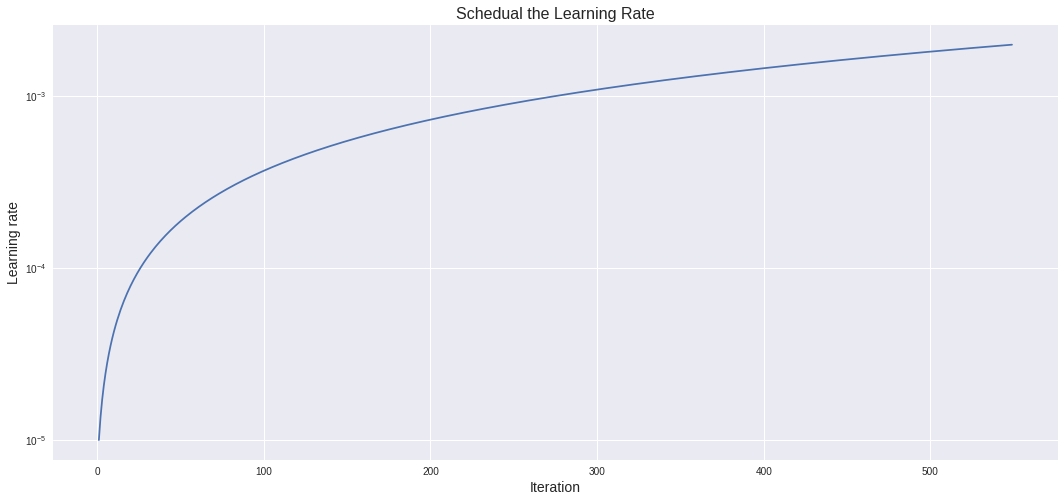

In [ ]:
#@title
plt.figure(figsize = [18,8])
plt.title('Schedual the Learning Rate',fontsize = 16)
plt.xlabel('Iteration', fontsize = 14)
plt.ylabel('Learing Rate', fontsize = 14)
lrf.plot_lr()

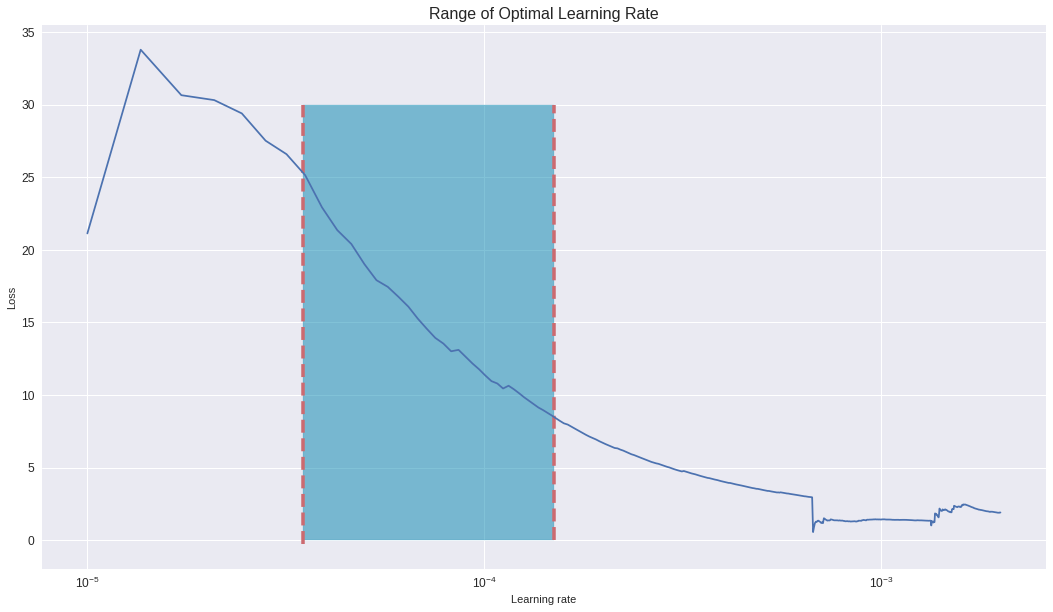

In [ ]:
#@title
plt.figure(figsize = [18,10])
plt.vlines(3.5e-5, ymin = -0.25, ymax = 30,linestyles = '--', color = '#CC6A70FF',lw = 3.5)
plt.vlines(1.5e-4, ymin = 0, ymax = 30, linestyles= '--', color = '#CC6A70FF', lw = 3.5)
plt.fill_between(y1 = 0, y2 = 30, x = [3.5e-5, 1.5e-4], color = '#0586B0',alpha = 0.5)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Range of Optimal Learning Rate',fontsize = 16)
lrf.plot_loss()

In [ ]:
model_wl.save_weights(mypath + '/output/model/modwl_findlr.h5')

## Fine-tune the Complete Model

In [ ]:
model_wl.load_weights(mypath + '/output/model/modwl_warmup.h5')

In [ ]:
#set up the learning rate 
LEARNING_RATE = 4e-5

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr =LEARNING_RATE)
model_wl.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=metric_list)

In [ ]:
qwk = QWK_Score(val_data = valid_generator,batch_size = BATCH_SIZE,save_best_mod = True, file_name = 'modwl')
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, epsilon = 0.0001, factor=DECAY_DROP, min_lr=1e-6, verbose=1)
csvl = CSVLogger(mypath + '/output/log/modwl_finetune_log1.csv',append = False)
cp = ModelCheckpoint(mypath + '/output/model/modwl_finetune1_vloss.h5', monitor='val_loss', verbose=1,
                     save_best_only=True, save_weights_only=True, mode='min', save_freq='epoch')

callback_list = [qwk,es,rlrop,csvl,cp]
history_finetuning_wl = model_wl.fit_generator(generator=train_generator,
                                               steps_per_epoch=STEP_SIZE_TRAIN,
                                               validation_data=valid_generator,
                                               validation_steps=STEP_SIZE_VALID,
                                               epochs=EPOCHS,
                                               callbacks=callback_list,
                                               verbose=1,
                                               class_weight=CLASS_WEIGHTS).history

Epoch 1/30
183/183 [==============================] - 416s 2s/step - loss: 2.8118 - accuracy: 0.6191 - val_loss: 12.2773 - val_accuracy: 0.4833
 - qwk_score: 0.000000

Epoch 00001: val_loss improved from inf to 12.27726, saving model to /content/drive/MyDrive/APTOS_Blindness_Detection/output/model/modwl_finetune1_vloss.h5
Epoch 2/30
183/183 [==============================] - 413s 2s/step - loss: 1.1537 - accuracy: 0.6393 - val_loss: 6.2889 - val_accuracy: 0.4833
 - qwk_score: 0.000000

Epoch 00002: val_loss improved from 12.27726 to 6.28889, saving model to /content/drive/MyDrive/APTOS_Blindness_Detection/output/model/modwl_finetune1_vloss.h5
Epoch 3/30
183/183 [==============================] - 410s 2s/step - loss: 1.0080 - accuracy: 0.6932 - val_loss: 6.3634 - val_accuracy: 0.4806
 - qwk_score: 0.000000

Epoch 00003: val_loss did not improve from 6.28889
Epoch 4/30
183/183 [==============================] - 411s 2s/step - loss: 0.8251 - accuracy: 0.7464 - val_loss: 6.4720 - val_accur

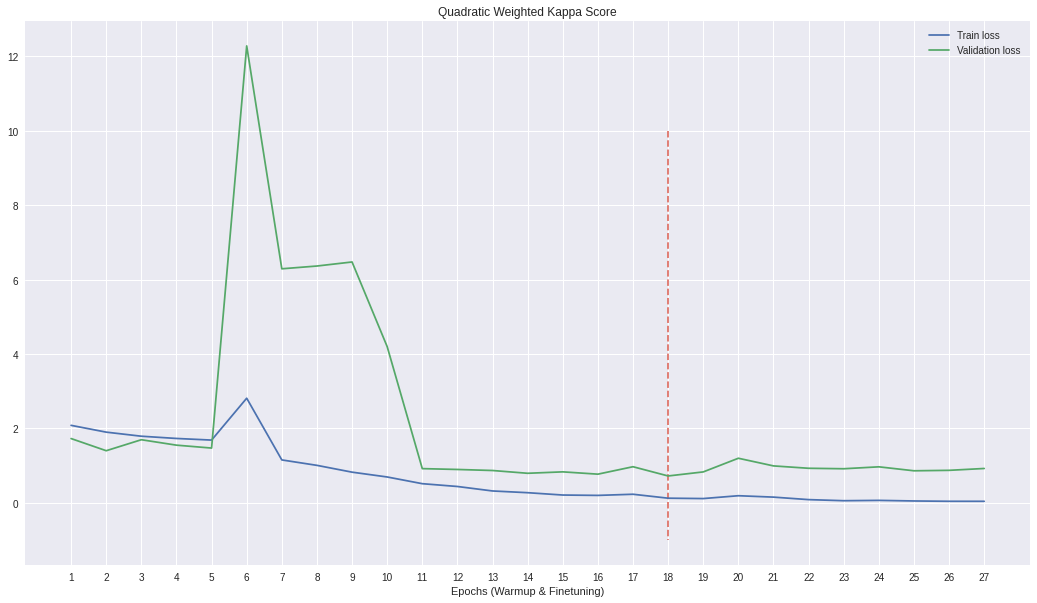

In [ ]:
#@title
plt.vlines(x = 17,ymin = 10, ymax = -1, linestyles = '--', color = '#de7065ff')
plt.xlabel('Epochs (Warmup & Finetuning)')
plt.title('Quadratic Weighted Kappa Score')
plot_fit_history(fit_hist = [history_warmup2,history_finetuning_wl])

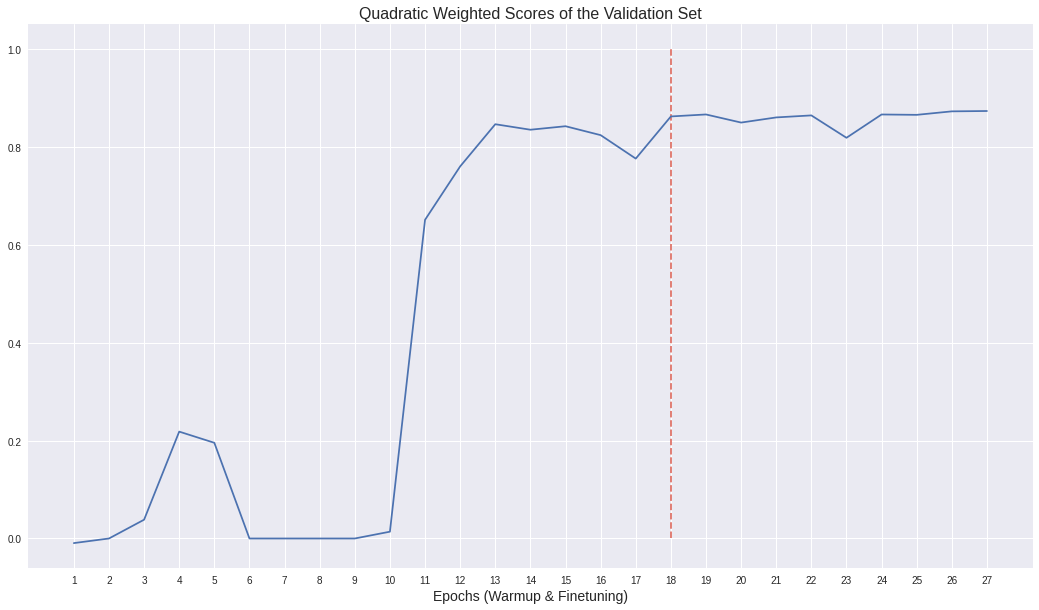

In [ ]:
#@title
total_epoches = len(qwk_warmup_wl.qwk_scores) + len(qwk.qwk_scores)

plt.plot(qwk_warmup_wl.qwk_scores + qwk.qwk_scores)
plt.vlines(x = 17,ymin = 0, ymax = 1, linestyles = '--', color = '#de7065ff')
plt.xticks(np.arange(total_epoches),np.arange(1,total_epoches + 1))
plt.xlabel('Epochs (Warmup & Finetuning)',fontsize = 14)
plt.title('Quadratic Weighted Scores of the Validation Set',fontsize = 16);

# Model Evaluation & Model Selection

## Candidate Model 1 (average cross-entropy loss)

In [ ]:
#model_2 = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)
model_2.load_weights(mypath + '/output/model/mod2_finetune2_vloss.h5')

#Predict Training Generator
train_generator.shuffle = False
train_generator.reset()
STEP_SIZE = train_generator.n/train_generator.batch_size

train_preds = model_2.predict_generator(train_generator, steps= STEP_SIZE)
train_preds = np.argmax(train_preds,axis = 1)

#predict validation set 
valid_generator.shuffle = False
valid_generator.reset()
STEP_SIZE = valid_generator.n/valid_generator.batch_size

valid_preds = model_2.predict_generator(valid_generator, steps= STEP_SIZE)
valid_preds = np.argmax(valid_preds,axis = 1)

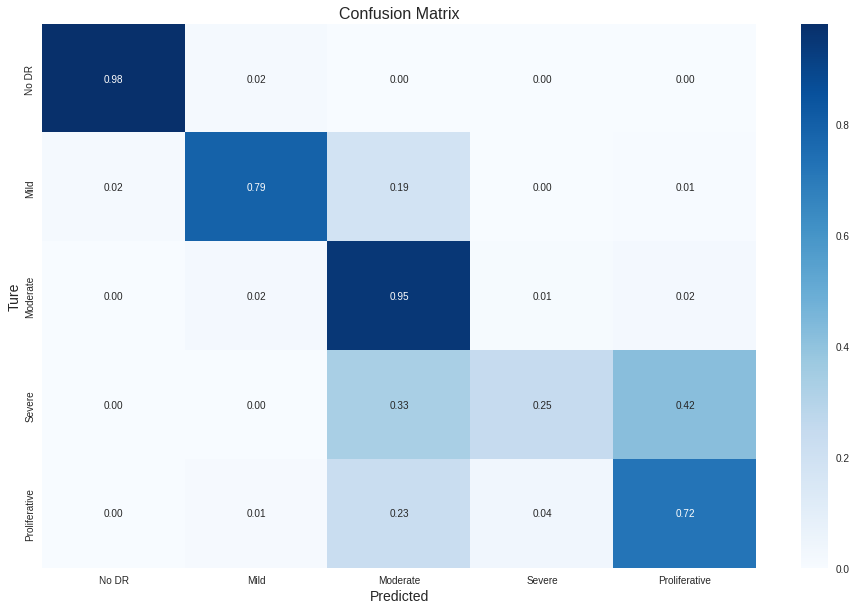

In [ ]:
#@title Confusion Matrix On Training Data
train_true = np.reshape(train_generator.classes,None)
labels = {0:'No DR', 1:'Mild', 2:'Moderate', 3:'Severe', 4:'Proliferative'}

cnf_matrix = confusion_matrix(train_true,train_preds,normalize = 'true')
plt.figure(figsize=(16, 10))
sns.heatmap(cnf_matrix, fmt='.2f', cmap="Blues",yticklabels = labels.values(),xticklabels = labels.values(),annot= True)
plt.ylabel('Ture',fontsize = 14)
plt.xlabel('Predicted',fontsize =14)
plt.title('Confusion Matrix',fontsize= 16)
plt.show()

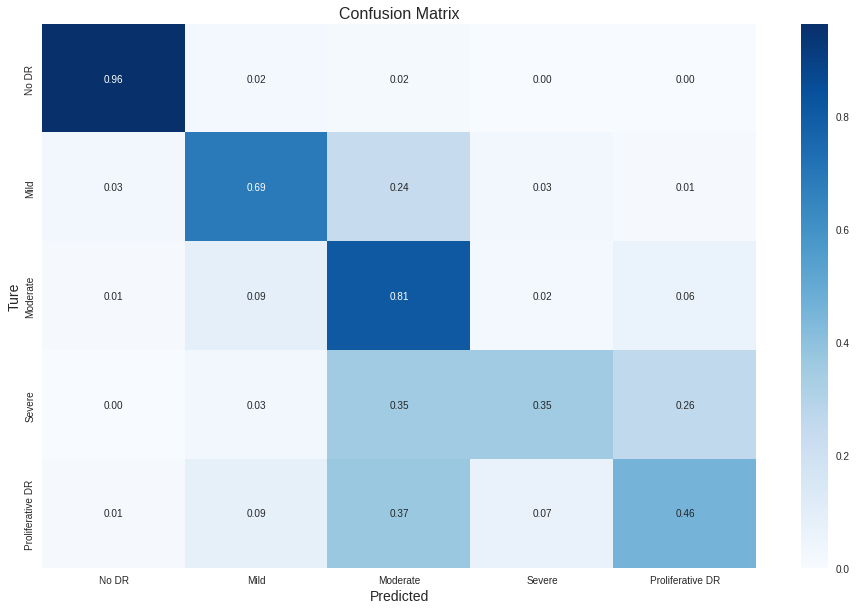

In [ ]:
#@title Confusion Matric On Validation Set
#make sure the shape of true value is same as the prediction's
valid_true = np.reshape(valid_generator.classes,None)

#plot the confusion matrix
cnf_matrix = confusion_matrix(valid_true,valid_preds,normalize = 'true')
plt.figure(figsize=(16, 10))
sns.heatmap(cnf_matrix, fmt='.2f', cmap="Blues",yticklabels = labels.values(),xticklabels = labels.values(),annot= True)
plt.ylabel('Ture',fontsize = 14)
plt.xlabel('Predicted',fontsize =14)
plt.title('Confusion Matrix',fontsize= 16)
plt.show()

1. The patterns on the training and validation confusion matrices are very close, which indicates the model performs consistently on the unseen data. 
2. The model is good at identifying No DR and Moderate classes but can do better for the rest classes in future improvement. The recalls of the validation set achieve 96% on No DR while 35% and 46% on Severe and Proliferative DR. The difference in performance is caused by unequally distributed classes.
3. Severe, Proliferative, and Mild DR are mostly misclassified as Moderate.
4. In addition to Moderate, the model has a hard time distinguishing Severe from Proliferative DR. There is a 35% chance a Severe sample classified as Moderate and 25% chance classified as Proliferative DR.


In [ ]:
#@title Classification Report On Training Data
print(classification_report(train_true, train_preds,target_names = labels.values()))

               precision    recall  f1-score   support

        No DR       1.00      0.98      0.99      1452
         Mild       0.84      0.79      0.81       299
     Moderate       0.82      0.95      0.88       792
       Severe       0.73      0.25      0.37       162
Proliferative       0.65      0.72      0.68       225

     accuracy                           0.89      2930
    macro avg       0.81      0.74      0.75      2930
 weighted avg       0.89      0.89      0.88      2930



In [ ]:
#@title Classification Report On Validation Data
print(classification_report(valid_true, valid_preds,target_names = labels.values()))

                  precision    recall  f1-score   support

           No DR       0.98      0.96      0.97       353
            Mild       0.60      0.69      0.64        71
        Moderate       0.74      0.81      0.77       207
          Severe       0.50      0.35      0.42        31
Proliferative DR       0.59      0.46      0.52        70

        accuracy                           0.82       732
       macro avg       0.68      0.66      0.66       732
    weighted avg       0.82      0.82      0.82       732



In [ ]:
#@title Quadratic Weighted Kappa Score On Training Data
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds,train_true, weights='quadratic'))

Train Cohen Kappa score: 0.938


In [ ]:
#@title Quadritic Weigthed Kappa Score On Validation Data
print("Validation Cohen Kappa score: %.3f" % cohen_kappa_score(valid_preds,valid_true, weights='quadratic'))

Validation Cohen Kappa score: 0.854


Again, Quadratic Weighted Kappa score takes a value between -1 and 1. When QWK score is negative, it implies that the model is "worse than random", so a random model should give a score around 0. Perfect predictions will yield a score of 1. We have 0.938 on training data and 0.854 on validation data, which are decent scores.


## Candidate Model 2 (weighted cross-entropy loss)

In [ ]:
#model_wl = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)
model_wl.load_weights(mypath + '/output/model/modwl_finetune1_vloss.h5')

#predict training generator
train_generator.shuffle = False
train_generator.reset()
STEP_SIZE = train_generator.n/train_generator.batch_size

train_preds = model_wl.predict_generator(train_generator, steps= STEP_SIZE)
train_preds = np.argmax(train_preds,axis = 1)

#predict Validation generator
valid_generator.shuffle = False
valid_generator.reset()
STEP_SIZE = valid_generator.n/valid_generator.batch_size

valid_preds = model_wl.predict_generator(valid_generator, steps= STEP_SIZE)
valid_preds = np.argmax(valid_preds,axis = 1)

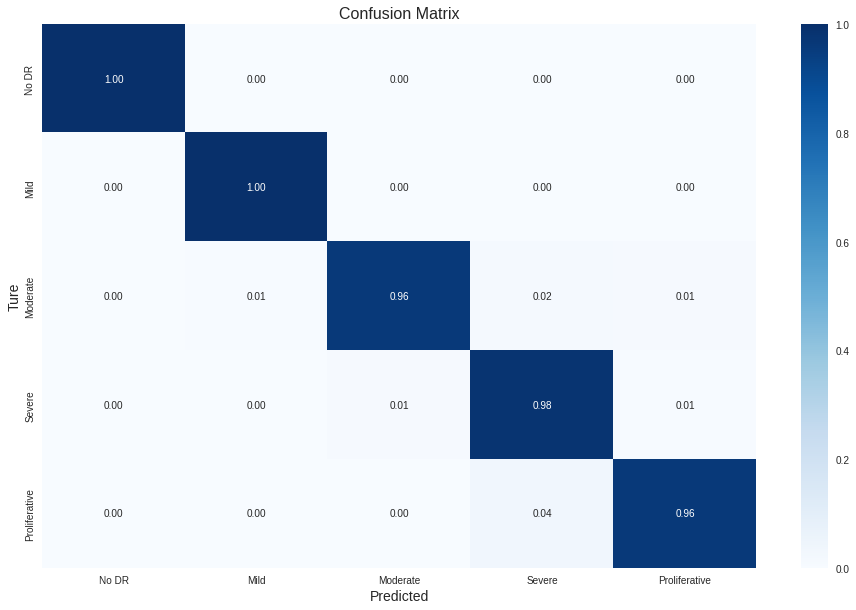

In [ ]:
#@title Confusion Matrix On Training Data
train_true = np.reshape(train_generator.classes,None)

cnf_matrix = confusion_matrix(train_true,train_preds,normalize = 'true')
plt.figure(figsize=(16, 10))
sns.heatmap(cnf_matrix, fmt='.2f', cmap="Blues",yticklabels = labels.values(),xticklabels = labels.values(),annot= True)
plt.ylabel('Ture',fontsize = 14)
plt.xlabel('Predicted',fontsize =14)
plt.title('Confusion Matrix',fontsize= 16)
plt.show()

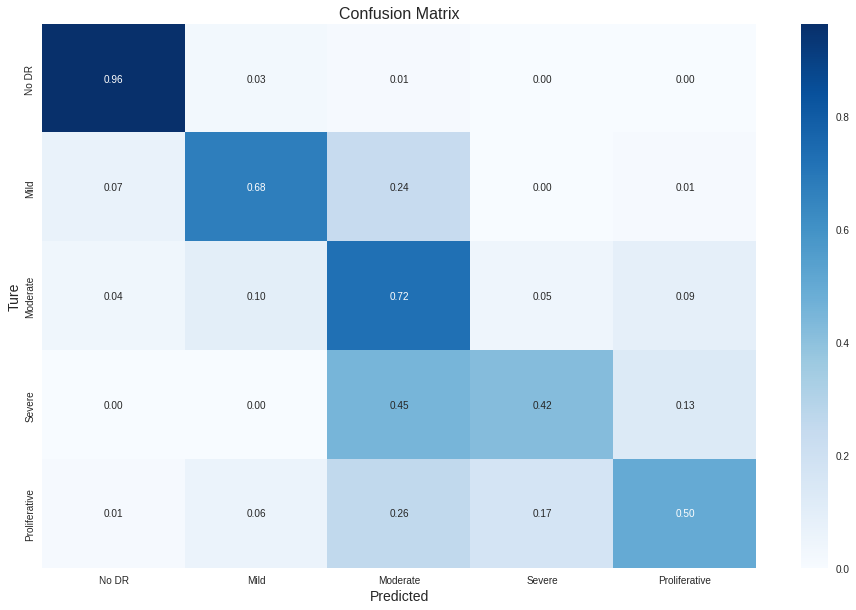

In [ ]:
#@title Confusion Matrix On Validation Data
#make sure the shape of true value is same as the prediction's
valid_true = np.reshape(valid_generator.classes,None)

#plot the confusion matrix
cnf_matrix = confusion_matrix(valid_true,valid_preds,normalize = 'true')
plt.figure(figsize=(16, 10))
sns.heatmap(cnf_matrix, fmt='.2f', cmap="Blues",yticklabels = labels.values(),xticklabels = labels.values(),annot= True)
plt.ylabel('Ture',fontsize = 14)
plt.xlabel('Predicted',fontsize =14)
plt.title('Confusion Matrix',fontsize= 16)
plt.show()



1.   The model seems to overfit the training data. There is a notable gap between the training and validation results. The model performs perfectly on all classes in training but not in validation.
2.   Compared to the last model, the recalls on minorities may be a bit better, given comparatively higher recalls on Severe and Proliferative.




In [ ]:
#@title Classification Report On Training Data
print(classification_report(train_true, train_preds,target_names = labels.values()))

               precision    recall  f1-score   support

        No DR       1.00      1.00      1.00      1452
         Mild       0.97      1.00      0.98       299
     Moderate       1.00      0.96      0.98       792
       Severe       0.88      0.98      0.93       162
Proliferative       0.95      0.96      0.96       225

     accuracy                           0.98      2930
    macro avg       0.96      0.98      0.97      2930
 weighted avg       0.99      0.98      0.98      2930



In [ ]:
#@title Classification Report on Validation Data
print(classification_report(valid_true, valid_preds,target_names = labels.values()))

                  precision    recall  f1-score   support

           No DR       0.98      0.96      0.97       353
            Mild       0.60      0.69      0.64        71
        Moderate       0.74      0.81      0.77       207
          Severe       0.50      0.35      0.42        31
Proliferative DR       0.59      0.46      0.52        70

        accuracy                           0.82       732
       macro avg       0.68      0.66      0.66       732
    weighted avg       0.82      0.82      0.82       732



In [ ]:
#@title Quadratic Weighted Cohen Kappa Score
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds,train_true, weights='quadratic'))

Train Cohen Kappa score: 0.992


In [ ]:
#@title Quadratic Weighted Cohen Kappa Score
print("Validation Cohen Kappa score: %.3f" % cohen_kappa_score(valid_preds,valid_true, weights='quadratic'))

Train Cohen Kappa score: 0.862


Again, there is a large gap between training and validation QWK scores. This reveals that the model is learning the noise of the training data. Even though the QWK scores of this model are slightly higher than 0.938 and 0.854 of the last model , we will choose the last model as our final model because it provide more stable performance on the unseen data.

## Evaluating the Whole Training Set (Training + Validation) By Final Model

In [ ]:
#create a new generator that containes the training set and validation set
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(  
        dataframe=train_new,
        directory = mypath + "/input/aptos2019-blindness-detection/train_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

#predict the generator
STEP_SIZE_COMPLETE = complete_generator.n/complete_generator.batch_size
train_preds = model_2.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE)
#the predicted value of a sample is a list of probability with respect to 5 classes, 
#so return the class with the max probability
train_preds = np.argmax(train_preds,axis = 1)

Found 3662 validated image filenames.


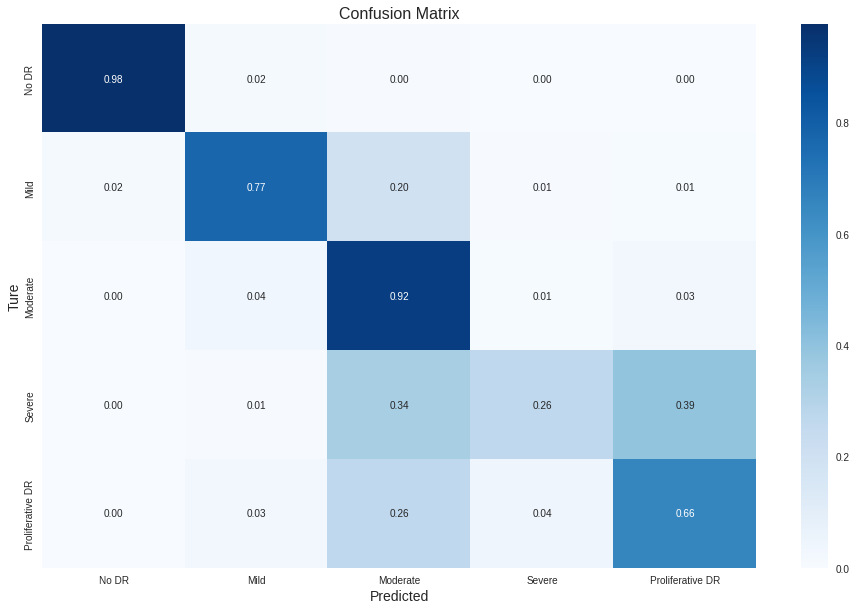

In [ ]:
#@title Confusion Matrix on the Whole Training Set
train_true = np.reshape(complete_generator.classes,None)

cnf_matrix = confusion_matrix(train_true
,train_preds,normalize = 'true')
plt.figure(figsize=(16, 10))
sns.heatmap(cnf_matrix, fmt='.2f', cmap="Blues",yticklabels = labels.values(),xticklabels = labels.values(),annot= True)
plt.ylabel('Ture',fontsize = 14)
plt.xlabel('Predicted',fontsize =14)
plt.title('Confusion Matrix',fontsize= 16)
plt.show()

In [ ]:
#@title Classification Report on the Whole Training Set
print(classification_report(train_new['diagnosis'].astype('int'), train_preds,target_names = labels.values()))

                  precision    recall  f1-score   support

           No DR       0.99      0.98      0.98      1805
            Mild       0.79      0.77      0.78       370
        Moderate       0.80      0.92      0.86       999
          Severe       0.66      0.26      0.38       193
Proliferative DR       0.64      0.66      0.65       295

        accuracy                           0.88      3662
       macro avg       0.78      0.72      0.73      3662
    weighted avg       0.87      0.88      0.87      3662



In [ ]:
#@title Quadratic Weighted Kappa on the Whole Training Set
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, train_new['diagnosis'].astype('int'), weights='quadratic'))

Train Cohen Kappa score: 0.921


# Apply model to test set and output predictions

In [ ]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n / test_generator.batch_size
test_preds = model_2.predict_generator(test_generator, steps=STEP_SIZE_TEST)
test_preds = np.argmax(test_preds,axis = 1)

In [ ]:
filenames = test_generator.filenames
results = pd.DataFrame({'id_code':filenames, 'diagnosis':test_preds})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])
results.to_csv(mypath + '/output/results/test_results.csv',index=False)
results.head(10)

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,2
2,006efc72b638,4
3,00836aaacf06,2
4,009245722fa4,2
5,009c019a7309,3
6,010d915e229a,2
7,0111b949947e,1
8,01499815e469,3
9,0167076e7089,2


## Predictions class distribution

In [ ]:
results = pd.read_csv(mypath + '/output/results/test_results.csv')
labels = {0:'No DR', 1:'Mild', 2:'Moderate', 3:'Severe', 4:'Proliferative'}

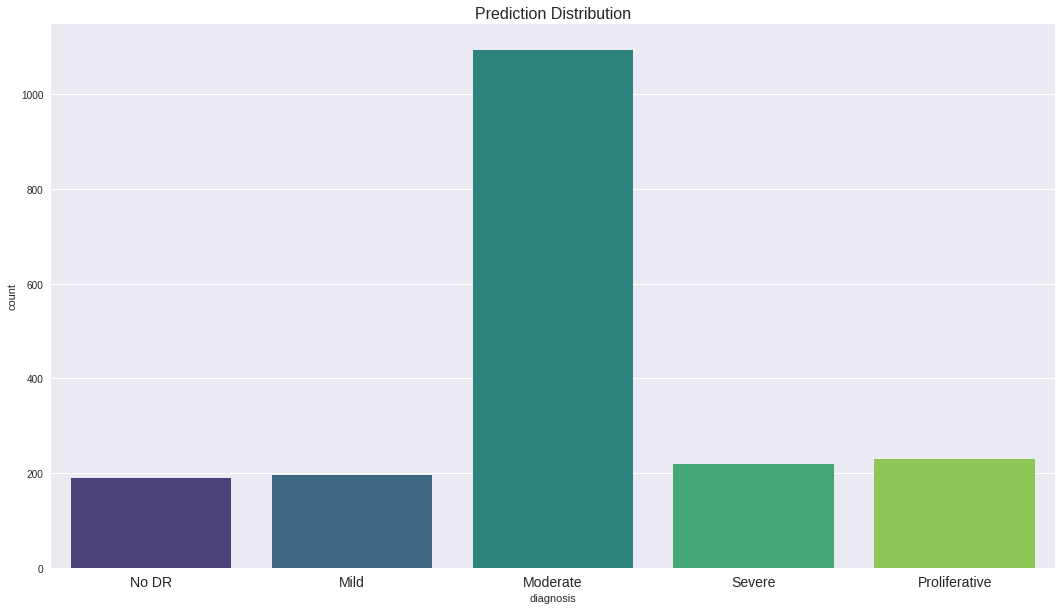

In [ ]:
sns.countplot(x="diagnosis", data=results, palette="viridis")
plt.xticks(list(labels),labels.values(),fontsize = 14)
plt.title('Prediction Distribution',fontsize = 16)
plt.show()

The graph shows that the majority of our predictions are Moderate and the rest are nearly equally shared by the other classes. 
This character may suggest that the test set has different data distribution from the training set since our model tends to predict the majority class (No DR) of our training data, yet in these predictions, No DR accounts for a relatively small amount. Meanwhile, the test set may contains higher percentage of Severe and Proliferative DR, compared to training set.

# Short Summary

From the begining to the end of this notebook, I used ResNet50 Models. I started with comparing three warmup models with batches size 16,32, and 64.  The warmup models were set to a learning rate that was very samll and gradully grew to a conventional 'initial' learning rate 1e-3 step-wise. Besides, their top 5 layers were set to be trainable whereas the rest were frozen. The whole purpose of the warmup is to reduce the impact of devating model from learning on sudden new data set exposure. I would also like to know which batch size would help the models learn fastest, keeping other paramters unchanged. The result suggested that the models were more sensitive to batch size 16 and converged better, so I could fix the batch size and find the optimal learning rate in the following step. When the network's loss decreases the fastest with a certain learning rate, then that learning rate is an optimal one. Then, I tracked the loss at the end of each step by performing a simple experiment where learning rate increased on a exponential scale each mini batch, where the learning rate started with 1e^-5 and ended with 1e^-2. Our results showed that the loss droped most rapidly around learning rate 6e-5. Next, I continued to trained the model for 30 epoches, set early stopping with val_loss mintor and saved model when the best val_loss and qwk score reach the highest. At the end, I got my first candiate model. For the second candidate model, I applied the same techniques as above. The only difference between the first and the second candidate models was the first candidate model used average cross-entrophy loss while the second candidate model used the weighted cross-entrophy loss. Imbalance data will impact the model to identify the minorities, so I was interested in if weighted loss would help the model learn the minoirites better.. 

The evaluation results showed that the first candiate model performed consistently on both of the training and validation set,given its qwk scores were 0.938 and 0.854 respetively. The second candiate model gave 0.992 and 0.862, but this great gap between the socres revealed a strong sign of overfitting. Thus, our final model is the first candiate model, the one with average corss-entrophy loss. 






